# GoodReads Recommendations Data Preparation

## Table of Contents

1. Background
2. Business Understanding
3. Data Understanding
4. Data Preparation
    - 4.a. Book Metadata
        - 4.a.i. Exploring Publication Year Data 
        - 4.a.ii. Adding Genre Metadata
        - 4.a.iii. Adding Author Metadata
        - 4.a.iv. Editing Similar Books Metadata
    - 4.b. User Rating Data
        - 4.b.i. Cleaning the Review Text
        - 4.b.ii. Subsetting by a User's Number of Reviews
    - 4.c. Book Metadata + Reviews
        - 4.c.i. Aggregating Review Text Per-Book
        - 4.c.ii. Combining Per-Book Review Text and Book Descriptions


In [3]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt

import re
import ast

## 1. Background

## 2. Business Understanding

## 3. Data Understanding

## 4. Data Preparation

Note that the datasets are quite large, so they'll take some time to run. I've included comments with average run time for your information.

### 4.a. Book Metadata
I need the metadata of the books in a dataset for two reasons: first, In my collaborative filtering, I will be returning recommendations to users. I'd like to give them information about the books they are recommended. Second, content-based filtering requires finding similar books using their traits/qualities/features. Metadata like the number of pages and the book's description will act as those features.

In [7]:
# This took about 3 mins
cols = ['isbn', 'average_rating', 'similar_books', 'description', 'link', 'authors',
        'num_pages', 'book_id', 'ratings_count', 'title', 'publication_year']
json_reader = pd.read_csv('data/meta_gr.csv', chunksize=10000)

In [8]:
list_df = []
for chunk in json_reader:
    list_df.append(chunk[cols])

In [9]:
metadata = pd.concat(list_df)

In [41]:
metadata.head()

,isbn,average_rating,similar_books,description,link,authors,num_pages,book_id,ratings_count,title,publication_year
0,0312853122,4.00,[],NaN,https://www.goodreads.com/book/show/5333265-w-...,"[{'author_id': '604031', 'role': ''}]",256.0,5333265,3.0,W.C. Fields: A Life on Film,1984.0
1,0743509986,3.23,"['8709549', '17074050', '28937', '158816', '22...","Anita Diamant's international bestseller ""The ...",https://www.goodreads.com/book/show/1333909.Go...,"[{'author_id': '626222', 'role': ''}]",NaN,1333909,10.0,Good Harbor,2001.0
2,NaN,4.03,"['19997', '828466', '1569323', '425389', '1176...",Omnibus book club edition containing the Ladie...,https://www.goodreads.com/book/show/7327624-th...,"[{'author_id': '10333', 'role': ''}]",600.0,7327624,140.0,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",1987.0
3,0743294297,3.49,"['6604176', '6054190', '2285777', '82641', '75...",Addie Downs and Valerie Adler were eight when ...,https://www.goodreads.com/book/show/6066819-be...,"[{'author_id': '9212', 'role': ''}]",368.0,6066819,51184.0,Best Friends Forever,2009.0
4,0850308712,3.40,[],NaN,https://www.goodreads.com/book/show/287140.Run...,"[{'author_id': '149918', 'role': ''}]",NaN,287140,15.0,Runic Astrology: Starcraft and Timekeeping in ...,NaN


Column-by-column review:
- I will keep 'isbn', 'link', and 'title' because it can help users find the exact book when they are recommended it
- I will keep 'average_rating', 'num_pages', and 'ratings_count' to act as features in my content-based recommendation model and as descriptors for returned recommendations
- I will keep 'description' to act as a feature in my content-based recommendation model and as a descriptor for my returned recommendations. It will be NLP processed before entering the content-based model, in the content-based notebook (not here)
- I will keep 'similar_books' as a check for my model's recommendations. The user can see the what the dataset has currently determined are books similar to my model's recommendations
- I will keep 'authors' as a descriptor for my returned recommendations, but I will need to merge in the authors' names using a **separate authors dataset below in section (4.a.iii.)**
- The 'book_id' column is crucial for connecting this dataset to others
- I will **further explore the 'publication_year' column in section 4.a.i. below** to see if it is worth keeping as a feature in my content-based model recommender. Conceptually it could be helpful to recommend users books from the same time period as the one they've entered

Notably missing here is genre information from the books. I'll merge that in using a **separate genres dataset below in section (4.a.ii.)**

In [42]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2360655 entries, 0 to 2360654
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   isbn              object 
 1   average_rating    float64
 2   similar_books     object 
 3   description       object 
 4   link              object 
 5   authors           object 
 6   num_pages         float64
 7   book_id           int64  
 8   ratings_count     float64
 9   title             object 
 10  publication_year  float64
dtypes: float64(4), int64(1), object(6)
memory usage: 198.1+ MB


In [43]:
# Seeing if any feature columns have nulls
metadata.isna().sum()

isbn                983374
average_rating         524
similar_books            0
description         412249
link                   524
authors                  0
num_pages           764133
book_id                  0
ratings_count          524
title                   12
publication_year    599625
dtype: int64

#### 4.a.i Exploring Publication Year Data

In [48]:
metadata['publication_year'].value_counts()

publication_year
2013.0     163752
2014.0     156410
2012.0     151180
2015.0     135735
2016.0     122417
            ...  
1566.0          1
1402.0          1
19984.0         1
1596.0          1
3008.0          1
Name: count, Length: 740, dtype: int64

In [50]:
# Trying to see the earliest and latest published book
print('max year', max(metadata['publication_year']))
print('min year', min(metadata['publication_year']))

max year 65535.0
min year 0.0


In [53]:
# Creating a dataframe with all the publication years in descending order
year_descending_order = metadata['publication_year'].sort_values(ascending=False)
year_descending_order

226459     65535.0
85035      65535.0
534390     65535.0
319517     65535.0
140959     65535.0
            ...   
2360621        NaN
2360625        NaN
2360629        NaN
2360639        NaN
2360654        NaN
Name: publication_year, Length: 2360655, dtype: float64

In [54]:
# Looking at the top 30 of those publication years
year_descending_order.head(30)

226459     65535.0
85035      65535.0
534390     65535.0
319517     65535.0
140959     65535.0
1640838    65535.0
701395     65535.0
1770859    65535.0
617601     65535.0
751967     65535.0
2043172    65535.0
397142     65535.0
837174     65535.0
746041     65535.0
1116208    32014.0
153957     29017.0
768145     22016.0
205024     22015.0
680039     22014.0
1975188    22013.0
1392612    22012.0
148867     22012.0
1393912    22004.0
67328      21017.0
2001368    21016.0
1729546    21014.0
1578107    21014.0
1025164    21014.0
505653     21014.0
1225024    21012.0
Name: publication_year, dtype: float64

There are a lot of nonsense values in the year column. Even in the first 30 rows above, we see years like '21014' show up a lot. The original authors of the dataset have no provided a key shedding light on the meaning of these values.

Let's try and look at the distribution of publication year within meaningful limits (1300 - 2024 A.D.)

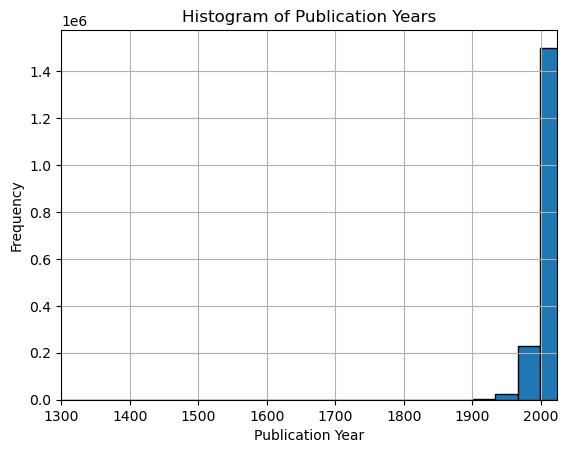

In [60]:
plt.hist(metadata['publication_year'], bins=2000, edgecolor='black') 
plt.xlabel('Publication Year')
plt.ylabel('Frequency')
plt.title('Histogram of Publication Years')
plt.xlim(1300, 2024)

plt.grid(True)
plt.show()

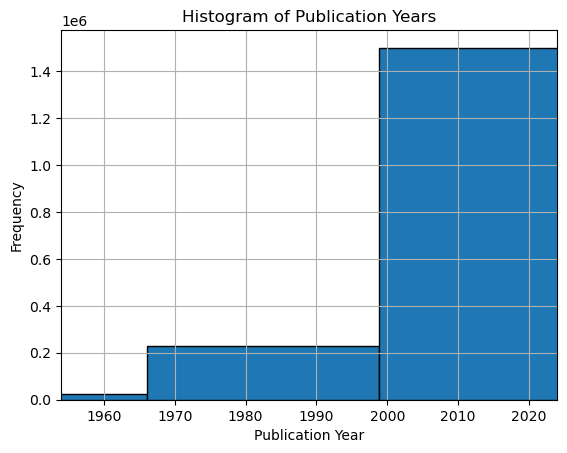

In [62]:
# Zooming in on the last 70 years
plt.hist(metadata['publication_year'], bins=2000, edgecolor='black') 
plt.xlabel('Publication Year')
plt.ylabel('Frequency')
plt.title('Histogram of Publication Years')
plt.xlim(1954, 2024)

plt.grid(True)
plt.show()

The vast majority of books are concentrated in 2000's - present. Due to this distribution + the large number of nulls + the non-semantic year entries (for which I cannot find a key from the owners of the dataset), I have decided to drop 'publication_year'.

In [10]:
metadata = metadata.drop(columns=['publication_year'])
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2360655 entries, 0 to 2360654
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   isbn            object 
 1   average_rating  float64
 2   similar_books   object 
 3   description     object 
 4   link            object 
 5   authors         object 
 6   num_pages       float64
 7   book_id         int64  
 8   ratings_count   float64
 9   title           object 
dtypes: float64(3), int64(1), object(6)
memory usage: 180.1+ MB


#### 4.a.ii. Adding Genre Metadata

In [45]:
# Loading in genre data
genres = pd.read_json('data/goodreads_book_genres_initial.json', lines=True)
genres.head()

,book_id,genres
0,5333265,"{'history, historical fiction, biography': 1}"
1,1333909,"{'fiction': 219, 'history, historical fiction,..."
2,7327624,"{'fantasy, paranormal': 31, 'fiction': 8, 'mys..."
3,6066819,"{'fiction': 555, 'romance': 23, 'mystery, thri..."
4,287140,{'non-fiction': 3}


In [5]:
genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2360655 entries, 0 to 2360654
Data columns (total 2 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   book_id  int64 
 1   genres   object
dtypes: int64(1), object(1)
memory usage: 36.0+ MB


In [17]:
genres['genres']

0              {'history, historical fiction, biography': 1}
1          {'fiction': 219, 'history, historical fiction,...
2          {'fantasy, paranormal': 31, 'fiction': 8, 'mys...
3          {'fiction': 555, 'romance': 23, 'mystery, thri...
4                                         {'non-fiction': 3}
                                 ...                        
2360650    {'non-fiction': 5, 'history, historical fictio...
2360651    {'mystery, thriller, crime': 4, 'children': 1,...
2360652    {'poetry': 14, 'children': 7, 'young-adult': 1...
2360653       {'romance': 13, 'mystery, thriller, crime': 2}
2360654                        {'romance': 19, 'fiction': 4}
Name: genres, Length: 2360655, dtype: object

It seems like the first genre (first key) in the dictionary is the highest voted one. I.e., the most users have categorized that book as that genre. 

I want to see what the highest number of genres one single book has been categorized as is. If the number of genres is extremely high, I may end up with too many features once I one-hot-encode the genres out.

In [19]:
# For loop for finding the book/row with the longest genre dictionary
longest_row_index = None
max_dict_length = 0

# Iterate over each row in the DataFrame
for index, row in genres.iterrows():
    # Check the length of the dictionary in the current row
    current_dict_length = len(row['genres'])
    # Update the maximum dictionary length and the index of the row if necessary
    if current_dict_length > max_dict_length:
        max_dict_length = current_dict_length
        longest_row_index = index

# Get the row with the longest dictionary
longest_genres_row = genres.loc[longest_row_index]

print("Row with the longest dictionary:")
print(longest_genres_row)

Row with the longest dictionary:
book_id                                             20622475
genres     {'poetry': 35, 'romance': 20, 'fiction': 31, '...
Name: 2887, dtype: object


In [21]:
# The book/row with the longest genres dictionary has been assigned 10 different genres
len(genres['genres'][2887])

10

In [24]:
# Here you can see that the genres are not listed in order of most to least votes
print(longest_row['genres'])

{'poetry': 35, 'romance': 20, 'fiction': 31, 'history, historical fiction, biography': 22, 'children': 24, 'young-adult': 4, 'fantasy, paranormal': 2, 'comics, graphic': 2, 'mystery, thriller, crime': 2, 'non-fiction': 1}


We can see two things from these results:
1. First, there is one book with 10 different genres assigned to it. This has two implications:
    - Keeping every single genre for every book might result in a dataframe with a lot of extra columns, and therefore an overfit model. 
    - It might be disingenous to categorize a book as multiple genres, when one of the genres has hundreds of votes, and the other has just a few (see the cell below, where the 'fiction' genre has 555 votes, and 'mystery, thriller, crime' has only 10). 
2. Second, the genres dictionary is NOT ordered in order of highest to lowest voted genre. 

In [28]:
# Here you can see that some books have a very extreme difference in vote number per genre
genres['genres'].iloc[3]

{'fiction': 555, 'romance': 23, 'mystery, thriller, crime': 10}

Due to point #1, I'd like to choose the genre that has the highest number of votes, and assign that to a new column called 'top_genre.' 

Due to point #2, when choosing genres I can't just pick out the first key in the genres dictionary as the final genre for that book. The first key/genre may not be the most voted genre for that book. Therefore, I need to write a function that identifies the key with the largest value.

In [46]:
# Function to create a 'top_genre' column
def get_top_genre(genres_dict):
    if not genres_dict:
        return None  # In case there are nulls in the 'genres' column
    top_genre = max(genres_dict, key=genres_dict.get) # Getting the key that has the largest value
    return top_genre

# Apply the function
genres['top_genre'] = genres['genres'].apply(get_top_genre)

genres.head()

,book_id,genres,top_genre
0,5333265,"{'history, historical fiction, biography': 1}","history, historical fiction, biography"
1,1333909,"{'fiction': 219, 'history, historical fiction,...",fiction
2,7327624,"{'fantasy, paranormal': 31, 'fiction': 8, 'mys...","fantasy, paranormal"
3,6066819,"{'fiction': 555, 'romance': 23, 'mystery, thri...",fiction
4,287140,{'non-fiction': 3},non-fiction


In [30]:
# Checking nulls
genres.isna().sum()

book_id           0
genres            0
top_genre    409513
dtype: int64

In [32]:
# Checking what those nulls look like
null_genres_df = genres[genres['genres'] == {}]
null_genres_df

,book_id,genres,top_genre
13,28575155,{},None
20,30227122,{},None
26,287142,{},None
27,16037548,{},None
36,24994796,{},None
...,...,...,...
2360615,35213446,{},None
2360617,33640526,{},None
2360625,31248182,{},None
2360635,31624372,{},None


The nulls are in rows with books that don't have assigned genres. They constitute 409,513 out of 2,360,655 books, or 17%. I'll keep these in as I need this dataset for returning the metadata of my recommendations, so I want to have as many books as are in the reviews dataset. 

Now I'll merge the top_genre data with the metadata dataframe using their shared column 'book_id'

In [47]:
top_genres = genres.drop(columns=['genres'])
top_genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2360655 entries, 0 to 2360654
Data columns (total 2 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   book_id    int64 
 1   top_genre  object
dtypes: int64(1), object(1)
memory usage: 36.0+ MB


In [48]:
# Merge metadata and genres DataFrames based on 'book_id' column
metadata = pd.merge(metadata, top_genres, how='left', on='book_id')

metadata.head()


,isbn,average_rating,similar_books,description,link,authors,num_pages,book_id,ratings_count,title,author_id,authors_names,top_genre
0,0312853122,4.00,[],NaN,https://www.goodreads.com/book/show/5333265-w-...,"[{'author_id': '604031', 'role': ''}]",256.0,5333265,3.0,W.C. Fields: A Life on Film,[604031],[Ronald J. Fields],"history, historical fiction, biography"
1,0743509986,3.23,"['8709549', '17074050', '28937', '158816', '22...","Anita Diamant's international bestseller ""The ...",https://www.goodreads.com/book/show/1333909.Go...,"[{'author_id': '626222', 'role': ''}]",NaN,1333909,10.0,Good Harbor,[626222],[Anita Diamant],fiction
2,NaN,4.03,"['19997', '828466', '1569323', '425389', '1176...",Omnibus book club edition containing the Ladie...,https://www.goodreads.com/book/show/7327624-th...,"[{'author_id': '10333', 'role': ''}]",600.0,7327624,140.0,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",[10333],[Barbara Hambly],"fantasy, paranormal"
3,0743294297,3.49,"['6604176', '6054190', '2285777', '82641', '75...",Addie Downs and Valerie Adler were eight when ...,https://www.goodreads.com/book/show/6066819-be...,"[{'author_id': '9212', 'role': ''}]",368.0,6066819,51184.0,Best Friends Forever,[9212],[Jennifer Weiner],fiction
4,0850308712,3.40,[],NaN,https://www.goodreads.com/book/show/287140.Run...,"[{'author_id': '149918', 'role': ''}]",NaN,287140,15.0,Runic Astrology: Starcraft and Timekeeping in ...,[149918],[Nigel Pennick],non-fiction


#### 4.a.iii. Adding Authors Metadata

In [13]:
# Seeing what one of the entries in the metadata dataframe's 'author' column looks like
metadata['authors'][88]

"[{'author_id': '7083555', 'role': ''}]"

The metadata dataset's 'authors' column contains a dictionary with the author id as a key and their role (most of which are blank strings) as a value. I have an 'authors' dataset that maps that author id to an author's name. I'll need to merge the two.

In [4]:
# Loading in author data
authors = pd.read_json('data/goodreads_book_authors.json', lines=True)
authors.head()

,average_rating,author_id,text_reviews_count,name,ratings_count
0,3.98,604031,7,Ronald J. Fields,49
1,4.08,626222,28716,Anita Diamant,546796
2,3.92,10333,5075,Barbara Hambly,122118
3,3.68,9212,36262,Jennifer Weiner,888522
4,3.82,149918,96,Nigel Pennick,1740


In [5]:
# Keeping only author id and their name
authors = authors.drop(columns=['average_rating', 'text_reviews_count', 'ratings_count'])
authors.head()

,author_id,name
0,604031,Ronald J. Fields
1,626222,Anita Diamant
2,10333,Barbara Hambly
3,9212,Jennifer Weiner
4,149918,Nigel Pennick


In [50]:
authors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829529 entries, 0 to 829528
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   author_id  829529 non-null  int64 
 1   name       829529 non-null  object
dtypes: int64(1), object(1)
memory usage: 12.7+ MB


I want to see if any books have multiple authors associated in the metdata dataset, and if so what the max number of authors is. 
I'll use a variation of the for loop from section **(4.a.ii.)** where I searched for the longest genres dictionary

In [11]:
# Loop for finding the author/row with the longest dictionary in metdata dataset
longest_row_index = None
max_dict_length = 0

# Iterate over each row in the DataFrame
for index, row in metadata.iterrows():
    # Check the length of the dictionary in the current row
    current_dict_length = len(row['authors'])
    # Update the maximum dictionary length and the index of the row if necessary
    if current_dict_length > max_dict_length:
        max_dict_length = current_dict_length
        longest_row_index = index

# Get the row with the longest dictionary
longest_authors_row = metadata.loc[longest_row_index]

print("Row with the longest authors dictionary:")
print(longest_authors_row)

Row with the longest authors dictionary:
isbn                                                     0981769667
average_rating                                                 4.38
similar_books                                                    []
description       ...the bounty of this] anthology reminded me o...
link              https://www.goodreads.com/book/show/12771197-f...
authors           [{'author_id': '5246175', 'role': 'Editor'}, {...
num_pages                                                     546.0
book_id                                                    12771197
ratings_count                                                  27.0
title                Fire in the Pasture: 21st Century Mormon Poets
Name: 157208, dtype: object


In [12]:
metadata['authors'][157208]

"[{'author_id': '5246175', 'role': 'Editor'}, {'author_id': '450926', 'role': ''}, {'author_id': '5246177', 'role': ''}, {'author_id': '5312013', 'role': ''}, {'author_id': '5246179', 'role': ''}, {'author_id': '3466493', 'role': ''}, {'author_id': '3172728', 'role': ''}, {'author_id': '5246180', 'role': ''}, {'author_id': '4529196', 'role': ''}, {'author_id': '5246181', 'role': ''}, {'author_id': '5246182', 'role': ''}, {'author_id': '461479', 'role': ''}, {'author_id': '4398788', 'role': ''}, {'author_id': '811635', 'role': ''}, {'author_id': '729760', 'role': ''}, {'author_id': '94070', 'role': ''}, {'author_id': '5246183', 'role': ''}, {'author_id': '5246184', 'role': ''}, {'author_id': '9616', 'role': ''}, {'author_id': '5246185', 'role': ''}, {'author_id': '5246186', 'role': ''}, {'author_id': '5246187', 'role': ''}, {'author_id': '5246188', 'role': ''}, {'author_id': '5246189', 'role': ''}, {'author_id': '5246190', 'role': ''}, {'author_id': '5246191', 'role': ''}, {'author_id':

In [13]:
len(metadata['authors'][157208])

3023

The book with the most authors has over 3k authors because it is a collection/anthology of poetry.

In [18]:
# Define a regular expression pattern to match the 'author_id' value
pattern = r"'author_id': '(\d+)'"

# Function to extract the author ID from a string
def extract_author_id(cell):
    # Search for the pattern in the string
    matches = re.findall(pattern, cell)
    if matches:
        # If matches are found, return the extracted author ID as an integer
        return [int(match) for match in matches]
    else:
        # If no matches are found, return None or any other appropriate value
        return None

# Apply the function to each cell in the 'author' column
metadata['author_id'] = metadata['authors'].apply(extract_author_id)

metadata.head()


,isbn,average_rating,similar_books,description,link,authors,num_pages,book_id,ratings_count,title,author_id
0,0312853122,4.00,[],NaN,https://www.goodreads.com/book/show/5333265-w-...,"[{'author_id': '604031', 'role': ''}]",256.0,5333265,3.0,W.C. Fields: A Life on Film,[604031]
1,0743509986,3.23,"['8709549', '17074050', '28937', '158816', '22...","Anita Diamant's international bestseller ""The ...",https://www.goodreads.com/book/show/1333909.Go...,"[{'author_id': '626222', 'role': ''}]",NaN,1333909,10.0,Good Harbor,[626222]
2,NaN,4.03,"['19997', '828466', '1569323', '425389', '1176...",Omnibus book club edition containing the Ladie...,https://www.goodreads.com/book/show/7327624-th...,"[{'author_id': '10333', 'role': ''}]",600.0,7327624,140.0,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",[10333]
3,0743294297,3.49,"['6604176', '6054190', '2285777', '82641', '75...",Addie Downs and Valerie Adler were eight when ...,https://www.goodreads.com/book/show/6066819-be...,"[{'author_id': '9212', 'role': ''}]",368.0,6066819,51184.0,Best Friends Forever,[9212]
4,0850308712,3.40,[],NaN,https://www.goodreads.com/book/show/287140.Run...,"[{'author_id': '149918', 'role': ''}]",NaN,287140,15.0,Runic Astrology: Starcraft and Timekeeping in ...,[149918]


Below I loc into the row that had 3k authors to see that I've captured the author_id of each one of those authors, not just the first

In [52]:
metadata.iloc[157208]

isbn                                                     0981769667
average_rating                                                 4.38
similar_books                                                    []
description       ...the bounty of this] anthology reminded me o...
link              https://www.goodreads.com/book/show/12771197-f...
authors           [{'author_id': '5246175', 'role': 'Editor'}, {...
num_pages                                                     546.0
book_id                                                    12771197
ratings_count                                                  27.0
title                Fire in the Pasture: 21st Century Mormon Poets
author_id         [5246175, 450926, 5246177, 5312013, 5246179, 3...
authors_names     [Tyler Chadwick, Neil Aitken, Matthew James Ba...
top_genre                                                    poetry
Name: 157208, dtype: object

In [34]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2360655 entries, 0 to 2360654
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   isbn            object 
 1   average_rating  float64
 2   similar_books   object 
 3   description     object 
 4   link            object 
 5   authors         object 
 6   num_pages       float64
 7   book_id         int64  
 8   ratings_count   float64
 9   title           object 
 10  author_id       object 
dtypes: float64(3), int64(1), object(7)
memory usage: 198.1+ MB


In [32]:
metadata.isna().sum()

isbn              983374
average_rating       524
similar_books          0
description       412249
link                 524
authors                0
num_pages         764133
book_id                0
ratings_count        524
title                 12
author_id            537
dtype: int64

Here I've written a function that will iterate through the newly created metadata['author_id'] column and replace every integer with the corresponding name from the authors['name'] colum in the authors dataframe. I will use the shared 'author_id' column in both the metadata and authors dataframes to do this

In [38]:
# Create a dictionary mapping author IDs to names
author_id_to_name = dict(zip(authors['author_id'], authors['name']))

# Function to replace author IDs with names in a list
def replace_author_ids_with_names(author_ids):
     if isinstance(author_ids, list):
        # Filter out author IDs not present in the dictionary
        return [author_id_to_name.get(author_id, 'Unknown') for author_id in author_ids]
     else:
        return ['Unknown']

# Apply the function to each list of author IDs in the 'authors' column
metadata['authors_names'] = metadata['author_id'].apply(replace_author_ids_with_names)

metadata.head()

,isbn,average_rating,similar_books,description,link,authors,num_pages,book_id,ratings_count,title,author_id,authors_names
0,0312853122,4.00,[],NaN,https://www.goodreads.com/book/show/5333265-w-...,"[{'author_id': '604031', 'role': ''}]",256.0,5333265,3.0,W.C. Fields: A Life on Film,[604031],[Ronald J. Fields]
1,0743509986,3.23,"['8709549', '17074050', '28937', '158816', '22...","Anita Diamant's international bestseller ""The ...",https://www.goodreads.com/book/show/1333909.Go...,"[{'author_id': '626222', 'role': ''}]",NaN,1333909,10.0,Good Harbor,[626222],[Anita Diamant]
2,NaN,4.03,"['19997', '828466', '1569323', '425389', '1176...",Omnibus book club edition containing the Ladie...,https://www.goodreads.com/book/show/7327624-th...,"[{'author_id': '10333', 'role': ''}]",600.0,7327624,140.0,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",[10333],[Barbara Hambly]
3,0743294297,3.49,"['6604176', '6054190', '2285777', '82641', '75...",Addie Downs and Valerie Adler were eight when ...,https://www.goodreads.com/book/show/6066819-be...,"[{'author_id': '9212', 'role': ''}]",368.0,6066819,51184.0,Best Friends Forever,[9212],[Jennifer Weiner]
4,0850308712,3.40,[],NaN,https://www.goodreads.com/book/show/287140.Run...,"[{'author_id': '149918', 'role': ''}]",NaN,287140,15.0,Runic Astrology: Starcraft and Timekeeping in ...,[149918],[Nigel Pennick]


In [39]:
# Checking that one of the rows with multiple authors had every author id replaced with
metadata.iloc[157208]

isbn                                                     0981769667
average_rating                                                 4.38
similar_books                                                    []
description       ...the bounty of this] anthology reminded me o...
link              https://www.goodreads.com/book/show/12771197-f...
authors           [{'author_id': '5246175', 'role': 'Editor'}, {...
num_pages                                                     546.0
book_id                                                    12771197
ratings_count                                                  27.0
title                Fire in the Pasture: 21st Century Mormon Poets
author_id         [5246175, 450926, 5246177, 5312013, 5246179, 3...
authors_names     [Tyler Chadwick, Neil Aitken, Matthew James Ba...
Name: 157208, dtype: object

In [40]:
# Checking that the author name in 'authors_name' matches the author_id from the authors dataframe
authors[authors['author_id'] == 5246175]

,author_id,name
128168,5246175,Tyler Chadwick


In [53]:
metadata = metadata.drop(columns=['authors', 'author_id'])
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2360655 entries, 0 to 2360654
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   isbn            object 
 1   average_rating  float64
 2   similar_books   object 
 3   description     object 
 4   link            object 
 5   num_pages       float64
 6   book_id         int64  
 7   ratings_count   float64
 8   title           object 
 9   authors_names   object 
 10  top_genre       object 
dtypes: float64(3), int64(1), object(7)
memory usage: 198.1+ MB


In [54]:
metadata.head()

,isbn,average_rating,similar_books,description,link,num_pages,book_id,ratings_count,title,authors_names,top_genre
0,0312853122,4.00,[],NaN,https://www.goodreads.com/book/show/5333265-w-...,256.0,5333265,3.0,W.C. Fields: A Life on Film,[Ronald J. Fields],"history, historical fiction, biography"
1,0743509986,3.23,"['8709549', '17074050', '28937', '158816', '22...","Anita Diamant's international bestseller ""The ...",https://www.goodreads.com/book/show/1333909.Go...,NaN,1333909,10.0,Good Harbor,[Anita Diamant],fiction
2,NaN,4.03,"['19997', '828466', '1569323', '425389', '1176...",Omnibus book club edition containing the Ladie...,https://www.goodreads.com/book/show/7327624-th...,600.0,7327624,140.0,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",[Barbara Hambly],"fantasy, paranormal"
3,0743294297,3.49,"['6604176', '6054190', '2285777', '82641', '75...",Addie Downs and Valerie Adler were eight when ...,https://www.goodreads.com/book/show/6066819-be...,368.0,6066819,51184.0,Best Friends Forever,[Jennifer Weiner],fiction
4,0850308712,3.40,[],NaN,https://www.goodreads.com/book/show/287140.Run...,NaN,287140,15.0,Runic Astrology: Starcraft and Timekeeping in ...,[Nigel Pennick],non-fiction


#### 4.a.iv. Editing Similar Books Metadata

In [55]:
# Replacing the 'similar_books' column string of book id's with the corresponding book titles

# Create a dictionary mapping book_id to title
book_id_title_map = dict(zip(metadata['book_id'], metadata['title']))

# Function to replace book_id with title
def replace_with_title(similar_books_str):
    similar_books = eval(similar_books_str)  # Convert string to list of book IDs
    titles = [book_id_title_map.get(int(book_id), '') for book_id in similar_books]  # Get titles for each book ID
    return titles

# Apply the function to each element in the 'similar_books' column
metadata['similar_books'] = metadata['similar_books'].apply(replace_with_title)

metadata.head()


,isbn,average_rating,similar_books,description,link,num_pages,book_id,ratings_count,title,authors_names,top_genre
0,0312853122,4.00,[],NaN,https://www.goodreads.com/book/show/5333265-w-...,256.0,5333265,3.0,W.C. Fields: A Life on Film,[Ronald J. Fields],"history, historical fiction, biography"
1,0743509986,3.23,[Hope Will Find You: My Search for the Wisdom ...,"Anita Diamant's international bestseller ""The ...",https://www.goodreads.com/book/show/1333909.Go...,NaN,1333909,10.0,Good Harbor,[Anita Diamant],fiction
2,NaN,4.03,"[Through a Brazen Mirror, The Hound and the Fa...",Omnibus book club edition containing the Ladie...,https://www.goodreads.com/book/show/7327624-th...,600.0,7327624,140.0,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",[Barbara Hambly],"fantasy, paranormal"
3,0743294297,3.49,"[The Opposite of Me, Dune Road, A Summer Affai...",Addie Downs and Valerie Adler were eight when ...,https://www.goodreads.com/book/show/6066819-be...,368.0,6066819,51184.0,Best Friends Forever,[Jennifer Weiner],fiction
4,0850308712,3.40,[],NaN,https://www.goodreads.com/book/show/287140.Run...,NaN,287140,15.0,Runic Astrology: Starcraft and Timekeeping in ...,[Nigel Pennick],non-fiction


In [56]:
metadata['similar_books'][2]

['Through a Brazen Mirror',
 'The Hound and the Falcon (The Hound and the Falcon, #1-3)',
 'The Secret Books of Paradys III & IV (Secret Books of Paradys, #3-4)',
 'Child of Light: Mary Shelley',
 'A Blackbird in Silver (Blackbird, #1)',
 'The Youngest Miss Ward',
 'Three to Dorsai!',
 'Lord Darcy  (Lord Darcy, #1-3)',
 'The Many Coloured Land The Golden Torc',
 'Dragonslayer',
 'To the Stars',
 'The Angelic Avengers',
 'Der mechanische Prinz',
 'The Road to Ehvenor (Guardians of the Flame, #6)',
 'Oath of the Renunciates (Darkover #10/13)',
 'Mockingbird',
 'The Far Kingdoms (Anteros, #1)']

In [57]:
metadata.head()

,isbn,average_rating,similar_books,description,link,num_pages,book_id,ratings_count,title,authors_names,top_genre
0,0312853122,4.00,[],NaN,https://www.goodreads.com/book/show/5333265-w-...,256.0,5333265,3.0,W.C. Fields: A Life on Film,[Ronald J. Fields],"history, historical fiction, biography"
1,0743509986,3.23,[Hope Will Find You: My Search for the Wisdom ...,"Anita Diamant's international bestseller ""The ...",https://www.goodreads.com/book/show/1333909.Go...,NaN,1333909,10.0,Good Harbor,[Anita Diamant],fiction
2,NaN,4.03,"[Through a Brazen Mirror, The Hound and the Fa...",Omnibus book club edition containing the Ladie...,https://www.goodreads.com/book/show/7327624-th...,600.0,7327624,140.0,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",[Barbara Hambly],"fantasy, paranormal"
3,0743294297,3.49,"[The Opposite of Me, Dune Road, A Summer Affai...",Addie Downs and Valerie Adler were eight when ...,https://www.goodreads.com/book/show/6066819-be...,368.0,6066819,51184.0,Best Friends Forever,[Jennifer Weiner],fiction
4,0850308712,3.40,[],NaN,https://www.goodreads.com/book/show/287140.Run...,NaN,287140,15.0,Runic Astrology: Starcraft and Timekeeping in ...,[Nigel Pennick],non-fiction


In [58]:
# Saving off the metadata dataframe
metadata.to_csv('data/metadata.csv', index=False)

### 4.b. User Review Data

Here we want to end up with: rating, user id, book id, the review text for each user per book

In [60]:
# This took 6 mins to load in
reviews = pd.read_json('data/goodreads_reviews_spoiler.json.gz', compression='gzip', lines=True)

In [59]:
reviews.info()

NameError: name 'reviews' is not defined

In [57]:
# I only need user_id, review_sentences, rating, and book_id 
reviews_subset = reviews[['user_id', 'rating', 'book_id', 'review_sentences']]
reviews_subset.head()

,user_id,rating,book_id,review_sentences
0,8842281e1d1347389f2ab93d60773d4d,5,18245960,"[[0, This is a special book.], [0, It started ..."
1,8842281e1d1347389f2ab93d60773d4d,3,16981,"[[0, Recommended by Don Katz.], [0, Avail for ..."
2,8842281e1d1347389f2ab93d60773d4d,3,28684704,"[[0, A fun, fast paced science fiction thrille..."
3,8842281e1d1347389f2ab93d60773d4d,0,27161156,"[[0, Recommended reading to understand what is..."
4,8842281e1d1347389f2ab93d60773d4d,4,25884323,"[[0, I really enjoyed this book, and there is ..."


#### 4.b.i. Cleaning the Review Text

In [58]:
# The review sentences column is a list of each sentence with a number for the index at the beginning
reviews_subset['review_sentences'][2]

[[0, 'A fun, fast paced science fiction thriller.'],
 [0, "I read it in 2 nights and couldn't put it down."],
 [0,
  'The book is about the quantum theory of many worlds which states that all decisions we make throughout our lives basically create branches, and that each possible path through the decision tree can be thought of as a parallel world.'],
 [0,
  'And in this book, someone invents a way to switch between these worlds.'],
 [0, 'This was nicely alluded to/foreshadowed in this quote:'],
 [0, '"I think about all the choices we\'ve made that created this moment.'],
 [0, 'Us sitting here together at this beautiful table.'],
 [0,
  'Then I think of all the possible events that could have stopped this moment from ever happening, and it all feels, I don\'t know..." "What?"'],
 [0, '"So fragile."'],
 [0, 'Now he becomes thoughtful for a moment.'],
 [0,
  'He says finally, "It\'s terrifying when you consider that every thought we have, every choice we could possibly make, branches int

In [59]:
# Function to concatenate sentences and remove numbers and quotes
def concatenate_sentences(sentences):
    concatenated_text = ''
    for sentence_info in sentences:
        # Remove the number at the beginning of each sentence
        sentence = sentence_info[1]
        if sentence_info[0] == 1:
            sentence = sentence[1:]  # Remove the number at the beginning
        # Remove quotes around the sentence
        if sentence.startswith('"') and sentence.endswith('"'):
            sentence = sentence[1:-1]
        # Append the sentence to the concatenated text
        concatenated_text += sentence + ' '
    return concatenated_text.strip()  # Remove trailing space

# Apply the function to concatenate sentences in the 'review_sentences' column
reviews_subset['review_text'] = reviews_subset['review_sentences'].apply(concatenate_sentences)
reviews_subset['review_text'][2]

/var/folders/45/9490rsy120vgdzpsxzj4d3wr0000gn/T/ipykernel_30889/378747040.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_subset['review_sentences'] = reviews_subset['review_sentences'].apply(concatenate_sentences)


'A fun, fast paced science fiction thriller. I read it in 2 nights and couldn\'t put it down. The book is about the quantum theory of many worlds which states that all decisions we make throughout our lives basically create branches, and that each possible path through the decision tree can be thought of as a parallel world. And in this book, someone invents a way to switch between these worlds. This was nicely alluded to/foreshadowed in this quote: "I think about all the choices we\'ve made that created this moment. Us sitting here together at this beautiful table. Then I think of all the possible events that could have stopped this moment from ever happening, and it all feels, I don\'t know..." "What?" So fragile. Now he becomes thoughtful for a moment. He says finally, "It\'s terrifying when you consider that every thought we have, every choice we could possibly make, branches into a new world." his book can\'t be discussed without spoilers. t is a book about choice and regret. ver 

In [60]:
# Checking that review_sentences has been turned into one string
reviews_subset.head()

,user_id,rating,book_id,review_sentences
0,8842281e1d1347389f2ab93d60773d4d,5,18245960,This is a special book. It started slow for ab...
1,8842281e1d1347389f2ab93d60773d4d,3,16981,Recommended by Don Katz. Avail for free in Dec...
2,8842281e1d1347389f2ab93d60773d4d,3,28684704,"A fun, fast paced science fiction thriller. I ..."
3,8842281e1d1347389f2ab93d60773d4d,0,27161156,Recommended reading to understand what is goin...
4,8842281e1d1347389f2ab93d60773d4d,4,25884323,"I really enjoyed this book, and there is a lot..."


In [ ]:
# Dropping the review_sentences column
reviews_subset = reviews_subset.drop(columns=['review_sentences'])

#### 4.b.ii. Subsetting by A User's Number of Reviews

In [61]:
# I want to see how many individual (unique) users there are
user_vc = reviews_subset['user_id'].value_counts()
user_vc

user_id
aca760854b57ce2ec981df32e46dc96c    1815
843a44e2499ba9362b47a089b0b0ce75    1647
8e7e5b546a63cb9add8431ee6914cf59    1214
667b94d4c7e0b014bb6ab3636999e712    1189
c5b70e45e230a166bb00201662495d69    1165
                                    ... 
49e4ac9e5bc4f06039e6120de035738e       1
424fa9e638254075ebe6b4cba7310a91       1
1857263fbefd251fdac5cd6d468aa6e0       1
a0d87052bf1a80b01a9066744fb46e26       1
62e5c281998b211e61dab629ba595ef4       1
Name: count, Length: 18892, dtype: int64

In [62]:
# I want to see how many users I'd be left with if I only kept users who have written at least 5 reviews
users_vc_5 = user_vc[user_vc >=5 ].index
users_vc_5

Index(['aca760854b57ce2ec981df32e46dc96c', '843a44e2499ba9362b47a089b0b0ce75',
       '8e7e5b546a63cb9add8431ee6914cf59', '667b94d4c7e0b014bb6ab3636999e712',
       'c5b70e45e230a166bb00201662495d69', 'aed35dbc626957174ebedf3c555b63d0',
       'd7879573928a367edb1d1accf2372810', 'c0e0fda388f87af0deffad748c9c8b67',
       '422e76592e2717d5d59465d22d74d47c', 'ccf944f8aca6814c1ec21cad667b7123',
       ...
       '54b7ab241624ebbc4158968b48cdd680', 'aaf7d634af94f2c65c04511f80ebdf02',
       '5fcdf0b98fb5d2dea561f5b93b298f8e', '156503c1d86446fd175c965320cb2129',
       'ec4a85bca6494332b52e7257e84b0714', '7ece23a7577ee3377c206ad52a287a47',
       'fdfaa1eeddeb558af311d36eaac263d8', 'c7303bb03f7f4a96c89d44f0504d6b0f',
       '8593c4720b979d9531b023ef8abf0e6d', '58fe4880f1c5746d7311867093747775'],
      dtype='object', name='user_id', length=17268)

The length of the users_vc vs. the users_vc_5 has a difference of only 1,624 users, or 8% of users.

In [64]:
# Keeping only users who have written at least 5 reviews
reviews_subset_2 = reviews_subset[reviews_subset['user_id'].isin(users_vc_5)]

In [65]:
reviews_subset_2['user_id'].value_counts()

user_id
aca760854b57ce2ec981df32e46dc96c    1815
843a44e2499ba9362b47a089b0b0ce75    1647
8e7e5b546a63cb9add8431ee6914cf59    1214
667b94d4c7e0b014bb6ab3636999e712    1189
c5b70e45e230a166bb00201662495d69    1165
                                    ... 
f8b91520e708af9a6c2ea8b2739f28bb       5
3b206409e55a73ca47284a85d84e0cc1       5
fdfaa1eeddeb558af311d36eaac263d8       5
d7c4e0e475bf1421b37890416f4cf1b9       5
297142f776e6cd363a2bc2f7aaa11c81       5
Name: count, Length: 17268, dtype: int64

In [66]:
# We have about 25,500 unique books in the reviews df
reviews_subset_2['book_id'].value_counts()

book_id
11870085    2725
11235712    2276
2767052     2236
7260188     1983
16096824    1716
            ... 
385483         8
2535743        8
16070990       7
118349         7
16148398       1
Name: count, Length: 25475, dtype: int64

In [67]:
reviews_subset_2.info()
# It's fine for user_id to be an object b/c the user id has letters in it

<class 'pandas.core.frame.DataFrame'>
Index: 1373966 entries, 0 to 1378032
Data columns (total 4 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   user_id           1373966 non-null  object
 1   rating            1373966 non-null  int64 
 2   book_id           1373966 non-null  int64 
 3   review_sentences  1373966 non-null  object
dtypes: int64(2), object(2)
memory usage: 52.4+ MB


In [83]:
# Saving the review data
reviews_subset_2.to_csv('data/gr_reviews_clean.csv')


### 4.c. User Reviews by Book
I now need to create the dataset for content-based filtering. Here, each row should be one book and each column should be a feature (an x variable) that my model will use to measure the similarity of each book. My features will include the following:

- Most of the book metadata from the metadata dataset created in **section 4.a.**
- The review text from the user reviews dataset created partway through **section 4.b.**

I have two sources of text data for each book: the 'description' column in the metadata dataset, and the 'review_text' column in the user reviews dataset. I want all the text data for each book to be in one cell, so that I can appy natural language processing and vectorization to all the text as one. I'll do this in two steps:

- For the review text, I need to join all the reviews for each book into one string per book
- Then, I will add the book description text from the 'description' column in the metadata dataset to that cell. 

We start with 'reviews_subset' which is from before we dropped users that had written fewer than 5 reviews, because we want to keep as many reviews as possible per book.

#### 4.c.i. Aggregating Review Text Per-Book

In [89]:
reviews_per_book = reviews_subset.groupby(['book_id'], as_index=False).agg({'review_text': ' '.join})
reviews_per_book.head()

,book_id,string_tokens
0,1,one best book series think get better suspense...
1,2,first read book worst one harry potter series ...
2,3,remember trying time read always gave page ski...
3,5,one definitely good second one much happened r...
4,6,best harry potter book far followed closely bo...


In [91]:
# Locing into the joined reviews for book_id 1
reviews_per_book['review_text'][0]

'one best book series think get better suspense build terrific mysterious tale possible double crossing virtuousness delivers best emotional mix good versus evil meta micro scale since ally versus axis second world war first love book since year old got first book christmas hooked still several year book movie theme park later piece always dream magical world hogwarts always home said least favorite book enjoyed learning voldemort past took way much book school year much worth character ron hermione flat lack flavor leave harry alone submerge teen world filled hormone really like suddenly form one book another superficial blind cant care le harry voldemort make sense cried lot end book know happen still hut think knew true beginning knew rowling showing actually allied disguise expecting book full action definitively need happen order give room final book one change everything hoped could fun read book disappoint absolutely love charming aspect book book series sad book series almost g

In [92]:
# Checkingto see that the per-book reviews for book_id 1 match
# all the reviews for book_id 1 in the per-user per book gr_reviews_subset2 dataframe
reviews_subset[reviews_subset['book_id']==1]

,user_id,rating,book_id,review_sentences,list_tokens,string_tokens_,string_tokens
901,4672eb229c808b792b8ea95f01f19784,5,1,one of the best books in the series i think.,"[one, best, book, series, think]",one best book series think,one best book series think
1166,5f550cc8d90df1759eda1496621187d8,5,1,it only gets better as the suspense builds in ...,"[get, better, suspense, build, terrific, myste...",get better suspense build terrific mysterious ...,get better suspense build terrific mysterious ...
3027,d8c86e725d683042e9eec675f294d7d4,4,1,"first of all, im in love with these books sinc...","[first, love, book, since, year, old, got, fir...",first love book since year old got first book ...,first love book since year old got first book ...
4408,90c53a2210f33ada709caa5aed0993c2,5,1,this book didn't disappoint me at all. i absol...,"[book, disappoint, absolutely, love, charming,...",book disappoint absolutely love charming aspec...,book disappoint absolutely love charming aspec...
8315,c4f655f2ed79599a9259d7762313f3f3,2,1,urgh.,[urgh],urgh,urgh
...,...,...,...,...,...,...,...
1371766,9de1dd255bb10211df3dfe5152a16f1e,5,1,i really did not see any of what happened in t...,"[really, see, happened, book, coming, beginnin...",really see happened book coming beginning end ...,really see happened book coming beginning end ...
1372411,c979f17afc966aec05933fbcd65c941e,5,1,best book out of the series! it was (one of) m...,"[best, book, series, one, favorite, movie, wel...",best book series one favorite movie well expec...,best book series one favorite movie well expec...
1372854,0f52329fbd7afa66717148ba9dd4ac38,5,1,read (to greg) nov 2005,"[read, greg, nov, 2005]",read greg nov 2005,read greg nov 2005
1377083,a8f8dd7892906b084a27dac976f773f8,5,1,(reread june 2016) still 5 stars!,"[reread, june, 2016, still, star]",reread june 2016 still star,reread june 2016 still star


#### 4.c.ii. Combining Per-Book Review Text and Book Descriptions

In [ ]:
metadata_copy = metadata.copy()

In [ ]:
metadata_and_reviews = pd.merge(metadata_copy, reviews_per_book, how='left', on='book_id')
metadata_and_reviews.head()

In [ ]:
metadata_and_reviews['reviews_and_desc'] = metadata_and_reviews['review_text'] + ' ' + metadata_and_reviews['description']
metadata_and_reviews.drop(columns=['review_text', 'description'], inplace=True)
metadata_and_reviews.head()


In [ ]:
metadata_and_reviews.to_csv('data/gr_reviews_per_book.csv', index=False)